## Initial Setup

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-21 19:09:56.904304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 19:09:56.904377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 19:09:56.906322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# specify the date parsing format
date_format = '%m/%d'

# loading and visualizing dataset into a dataframe & split into 5min chunks
df = pd.read_csv('/kaggle/input/cloud-coverage-detection/train.csv', index_col='DATE (MM/DD)', parse_dates=True, date_format=date_format, dtype={1:'str'})
df.head()

,MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
DATE (MM/DD),,,,,,,,,,,,,,,,
01-Jan,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,0.0,9.95,271.3,806.779,0.0,0.219,0.0,0.0
01-Jan,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,0.0,8.20,272.9,806.840,0.0,0.206,0.0,0.0
01-Jan,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,0.0,6.70,288.8,806.876,0.0,0.148,0.0,0.0
01-Jan,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,0.0,7.70,294.0,806.823,0.0,0.235,0.0,0.0
01-Jan,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,0.0,7.20,285.5,806.762,0.0,0.182,0.0,0.0


<Axes: xlabel='DATE (MM/DD)'>

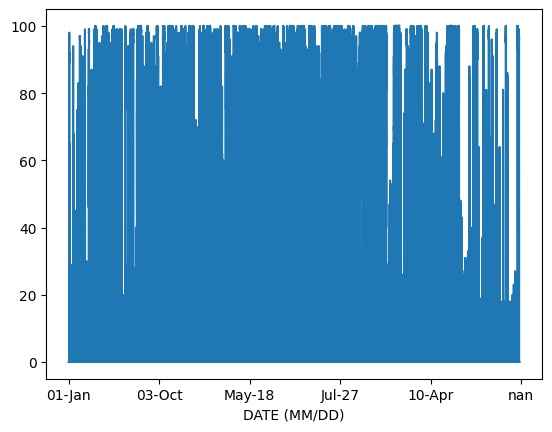

In [3]:
# plotting the cloud cover % wrt date (has missing values)
cloud_cover = df['Total Cloud Cover [%]']
cloud_cover.plot(kind='line')

---

## Pre-Processing

In [4]:
# check missing values in each column
missing_counts = df.isnull().sum()
print(missing_counts)

MST                                      44640
Global CMP22 (vent/cor) [W/m^2]          44640
Direct sNIP [W/m^2]                      44640
Azimuth Angle [degrees]                  44640
Tower Dry Bulb Temp [deg C]              44640
Tower Wet Bulb Temp [deg C]              44640
Tower Dew Point Temp [deg C]             44640
Tower RH [%]                             44640
Total Cloud Cover [%]                    46109
Peak Wind Speed @ 6ft [m/s]              44640
Avg Wind Direction @ 6ft [deg from N]    44640
Station Pressure [mBar]                  44640
Precipitation (Accumulated) [mm]         44640
Snow Depth [cm]                          44640
Moisture                                 44640
Albedo (CMP11)                           44640
dtype: int64


In [5]:
# imputation of target feature and feature selection for inputs
cols_to_use = ['Global CMP22 (vent/cor) [W/m^2]', 'Direct sNIP [W/m^2]', 'Tower Dry Bulb Temp [deg C]', 
               'Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]', 
               'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]', 'Station Pressure [mBar]', 
               'Precipitation (Accumulated) [mm]', 'Snow Depth [cm]', 'Albedo (CMP11)']

X = df[cols_to_use]
y = df['Total Cloud Cover [%]']

In [6]:
# converting df into np array to act as input vector
df = df[0:498240]
df.to_numpy()

array([['00:00', -0.962276, 0.0, ..., 0.219, 0.0, 0.0],
       ['00:01', -0.937921, 0.0, ..., 0.206, 0.0, 0.0],
       ['00:02', -0.944395, 0.0, ..., 0.148, 0.0, 0.0],
       ...,
       ['23:57', -1.11354, 1.13074, ..., 2.842, 0.0, 0.0],
       ['23:58', -1.1403, 1.18012, ..., 2.842, 0.0, 0.0],
       ['23:59', -1.17278, 1.18999, ..., 2.872, 0.0, 0.0]], dtype=object)

In [7]:
# conversion function
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
        
        return np.array(X), np.array(y)

In [10]:
window_size = 5
X1, y1 = df_to_X_y(cloud_cover, window_size)
X1.shape, y1.shape

((1, 5, 1), (1,))

In [12]:
# train test split (manual)
len(df)

X_train = X1.iloc[:398590]
X_test = X1.iloc[398590:498240]
y_train = y1.iloc[:398590]
y_test = y1.iloc[398590:498240]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
# calculate median excluding NaN values
median_y_train = y_train.median()
median_y_test = y_test.median()
# impute NaN values with median
y_train_imputed = y_train.fillna(median_y_train)
y_test_imputed = y_test.fillna(median_y_test)

### Run any 1 of the 2 cells below

In [ ]:
# imports for imputing
from sklearn.impute import SimpleImputer

# imputing input features
imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(imputer.transform(X_test))

# imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

# prevent data leakage (drop target feature from input feature set)
processed_X_train = imputed_X_train.drop('Total Cloud Cover [%]', axis=1)
processed_X_test = imputed_X_test.drop('Total Cloud Cover [%]', axis=1)

In [ ]:
# drop missing values
df = df.dropna(axis=0)

processed_X_train = X_train.drop('Total Cloud Cover [%]', axis=1)
processed_X_test = X_test.drop('Total Cloud Cover [%]', axis=1)

In [ ]:
# plotting the cloud cover % wrt date (after imputations)
y_train.plot(x=processed_X_train, kind='line')

---